In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pycbc import fft
from pycbc.filter import match, overlap_cplx, sigma, sigmasq, make_frequency_series
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.waveform import taper_timeseries
from pycbc.types import timeseries, frequencyseries, zeros, complex_same_precision_as
from calcwf import gen_wf, get_h, overlap_cplx_wfs, match_wfs, shifted_f, shifted_e, chirp2total, trim_wf, ceiltwo, taper_wf, gen_teob_wf, gen_psd

# Normalisation with 3 waveform components

As before will start with the following, now using the notation of labelling $h_0, \ldots, h_{n-1}$:

$$
h = Ah_0+Bh_1+Ch_2
$$
$$
h_0 = \frac{1}{3}\left(s_0+s_1+s_2\right)
$$
$$
h_1 = \frac{1}{3}\left(s_0+\omega s_1+\omega^2 s_2\right)
$$
$$
h_2 = \frac{1}{3}\left(s_0+\omega^2s_1+\omega s_2\right)
$$

where $\omega$ is the first primitive $n=3$ root of unity.

Here and throughout we will make extensive use of the following properties:

$$
(\lambda_1 \alpha_1 | \lambda_2 \alpha_2) = \lambda_1 \lambda_2^* (\alpha_1| \alpha_2)
$$

$$
(\omega^a)^* = \omega^{-a} = \omega^{n-a}
$$

We now want to enforce the condition

$$
\frac{(h|h_0)}{(h_0|h_0)} = A\frac{(h_0|h_0)}{(h_0|h_0)} + B\frac{(h_1|h_0)}{(h_0|h_0)} + C\frac{(h_2|h_0)}{(h_0|h_0)} = A
$$

which requires $(h_j|h_m) = 0$ for $j\neq m$.

From $n=2$ case we can normalise such that $(s_j|s_j)$ are equal for all $j$. We also expect $(s_0|s_1) = (s_1|s_2)  = (s_2|s_0)$ as they all differ by the same true anomaly (and similarly $(s_1|s_0) = (s_2|s_1) = (s_0|s_2)$).

For e.g. $(h_1|h_2)$, this comes down to enforcing

$$
(h_1|h_2) \propto (s_0|s_0) + \omega(s_0|s_1) + \omega^2(s_0|s_2) + \omega(s_1|s_0) + \omega^2(s_1|s_1) + (s_1|s_2) + \omega^2(s_2|s_0) + (s_2|s_1) + \omega(s_2|s_2) = 0
$$

$$
(1+\omega^2+\omega)(s_0|s_0) + (\omega+1+\omega^2)(s_0|s_1) + (\omega+1+\omega^2)(s_1|s_0) = 0
$$

$$
0 = 0
$$

We therefore see that simply normalising in the same way as the $n=2$ case also enforces $(h_1|h_2)$ to be zero in the $n=3$ case.

Repeat for $(h_0|h_1)$ and $(h_2|h_0)$ now to check these also equal zero:

$$
(h_0|h_1) \propto (s_0|s_0) + \omega^2(s_0|s_1) + \omega(s_0|s_2) + (s_1|s_0) + \omega^2(s_1|s_1) + \omega(s_1|s_2) + (s_2|s_0) + \omega^2(s_2|s_1) + \omega(s_2|s_2)
$$

$$
(h_0|h_1) \propto (1+\omega^2+\omega)(s_0|s_0) + (\omega^2+\omega+1)(s_0|s_1) + (1+\omega^2+\omega)(s_1|s_0)
$$

$$
(h_0|h_1) \propto 0
$$

and

$$
(h_2|h_0) \propto (s_0|s_0) + (s_0|s_1) + (s_0|s_2) + \omega^2(s_1|s_0) + \omega^2(s_1|s_1) + \omega^2(s_1|s_2) + \omega(s_2|s_0) + \omega(s_2|s_1) + \omega(s_2|s_2)
$$

$$
(h_2|h_0) \propto (1+\omega^2+\omega)(s_0|s_0) + (1+\omega^2+\omega)(s_0|s_1) + (\omega^2+\omega+1)(s_1|s_0)
$$

$$
(h_2|h_0) \propto 0
$$

We therefore find that the simple normalisation we used for $n=2$ also works in the $n=3$ case, allowing us to write:

$$
\frac{(h|h_0)}{(h_0|h_0)} = A\frac{(h_0|h_0)}{(h_0|h_0)} + B\frac{(h_1|h_0)}{(h_0|h_0)} + C\frac{(h_2|h_0)}{(h_0|h_0)} = A
$$
$$
\frac{(h|h_1)}{(h_1|h_1)} = A\frac{(h_0|h_1)}{(h_1|h_1)} + B\frac{(h_1|h_1)}{(h_1|h_1)} + C\frac{(h_2|h_1)}{(h_1|h_1)} = B
$$
$$
\frac{(h|h_2)}{(h_2|h_2)} = A\frac{(h_0|h_2)}{(h_2|h_2)} + B\frac{(h_1|h_2)}{(h_2|h_2)} + C\frac{(h_2|h_2)}{(h_2|h_2)} = C
$$

For completeness, let's also calculate all (h_j|h_j):

$$
(h_0|h_0) \propto (s_0|s_0) + (s_0|s_1) + (s_0|s_2) + (s_1|s_0) + (s_1|s_1) + (s_1|s_2) + (s_2|s_0) + (s_2|s_1) + (s_2|s_2)
$$

$$
(h_0|h_0) \propto 3(s_0|s_0) + 3(s_0|s_1) + 3(s_1|s_0)
$$

$$
(h_0|h_0) = \frac{1}{3}(s_0|s_0) + \frac{1}{3}(s_0|s_1) + \frac{1}{3}(s_1|s_0)
$$

$$
(h_1|h_1) \propto (s_0|s_0) + \omega^2(s_0|s_1) + \omega(s_0|s_2) + \omega(s_1|s_0) + (s_1|s_1) + \omega^2(s_1|s_2) + \omega^2(s_2|s_0) + \omega(s_2|s_1) + (s_2|s_2)
$$

$$
(h_1|h_1) \propto 3(s_0|s_0) + 3\omega^2(s_0|s_1) + 3\omega(s_1|s_0)
$$

$$
(h_1|h_1) = \frac{1}{3}(s_0|s_0) + \frac{\omega^2}{3}(s_0|s_1) + \frac{\omega}{3}(s_1|s_0)
$$

$$
(h_2|h_2) \propto (s_0|s_0) + \omega(s_0|s_1) + \omega^2(s_0|s_2) + \omega^2(s_1|s_0) + (s_1|s_1) + \omega(s_1|s_2) + \omega(s_2|s_0) + \omega^2(s_2|s_1) + 1(s_2|s_2)
$$

$$
(h_2|h_2) \propto 3(s_0|s_0) + 3\omega(s_0|s_1) + 3\omega^2(s_1|s_0)
$$

$$
(h_2|h_2) = \frac{1}{3}(s_0|s_0) + \frac{\omega}{3}(s_0|s_1) + \frac{\omega^2}{3}(s_1|s_0)
$$

# Normalisation with n waveform components

Now let's attempt to do this for $n$ waveform components. Note the subscript $j$ here refers to the order of the nth roots of unity eigenvectors, not the $h_1,\ldots,h_n$ in order of dominance. This order differs for $n>3$. (see Eigenvector Order Prediction in principal_component_analysis.ipynb for more details).

$$
h = \sum_{j=0}^{n-1} A_j h_j
$$
$$
h_j = \frac{1}{n}\sum_{k=0}^{n-1} \omega_n^{jk} s_k
$$

where $\omega_n$ is the first primitive $n$th root of unity, defined as equal to $e^{(2 \pi i/n)}$.

Now calculate $(h_j|h_m)$.

$$
(h_j|h_m) \propto \sum_{k=0}^{n-1} \sum_{l=0}^{n-1} \omega_n^{(jk-ml)} (s_k|s_l)
$$

Separate out diagonal terms:

$$
(h_j|h_m) \propto \sum_{k=0}^{n-1} \omega_n^{k(j-m)} (s_k|s_k) + \sum_{k,l=0 \atop k\neq l}^{n-1} \omega_n^{(jk-ml)} (s_k|s_l)
$$

And only sum over unique pairs:

$$
(h_j|h_m) \propto \sum_{k=0}^{n-1} \omega_n^{k(j-m)} (s_k|s_k) + \sum_{k=0}^{n-1}\sum_{l=k+1}^{n-1} \omega_n^{(jk-ml)} (s_k|s_l) + \sum_{k=0}^{n-1}\sum_{l=k+1}^{n-1}\omega_n^{(jl-mk)} (s_l|s_k)
$$

Can see immediately that the roots of unity in the first term will either all be 1 if $j=m$, or sum to zero otherwise, as $\sum_{k=0}^{n-1}\left(\omega_n^b\right)^k = 0$ for $b~\mathrm{mod}~n \neq 0$. The first term therefore disappears for $j\neq m$.

We can also now collect 'like-terms' in the off-diagonal sums by using e.g. $(s_0|s_1) = (s_1|s_2) = (s_2|s_3) = (s_3|s_0)$ and $(s_0|s_2) = (s_1|s_3)$ in the $n=4$ case.

$$
(h_j|h_m) \propto \sum_{k=0}^{n-1} \omega_n^{k(j-m)} (s_k|s_k) + \sum_{r=1}^{\lfloor n/2\rfloor} \sum_{t=0}^{p-1} \omega_n^{(jt-m(t+r))} (s_0|s_r) + \sum_{r=1}^{\lfloor n/2\rfloor} \sum_{t=0}^{p-1} \omega_n^{(j(t+r)-mt)} (s_r|s_0)
$$

where $\lfloor x \rfloor$ denotes the floor of $x$, and p is the number of pairs that can be made from the index difference $r$, equal to:

$$ p=   \left\{
\begin{array}{ll}
      0 & r>n/2 \\
      n/2 & r=n/2 \\
      n & r<n/2 \\
\end{array} 
\right.  $$

Simplifying slightly further,

$$
(h_j|h_m) \propto \sum_{k=0}^{n-1} \omega_n^{k(j-m)} (s_k|s_k) + \sum_{r=1}^{\lfloor n/2\rfloor} \omega_n^{-mr} \sum_{t=0}^{p-1} \omega_n^{t(j-m)} (s_0|s_r) + \sum_{r=1}^{\lfloor n/2\rfloor} \omega_n^{jr} \sum_{t=0}^{p-1} \omega_n^{t(j-m)} (s_r|s_0)
$$

We now see once again that for $j=m$, the coefficients $\omega_n^{t(j-m)}$ are simply all 1. We can now read off that for general $n$, $(h_j|h_j)$ is equal to:

$$
(h_j|h_j) = \frac{1}{n} (s_0|s_0) + \sum_{r=1}^{\lfloor n/2\rfloor} \frac{p}{n^2} \omega_n^{-jr} (s_0|s_r) + \sum_{r=1}^{\lfloor n/2\rfloor} \frac{p}{n^2} \omega_n^{jr} (s_r|s_0)
$$

which is consistent with the $n=3$ case we have calculated explicitly.

Returning to the $j\neq m$ case, for each $r$ being summed over, we can either have $p=n$, or $p=n/2$. In the former case, it is obvious that the off-diagonal terms reduce to zero in the same way as for the diagonal term, using $\sum_{t=0}^{n-1}\left(\omega_n^b\right)^t = 0$.

For the $p=n/2$ case, we recognise that $n$ must be even as $r=n/2$. We also have for this case $(s_0|s_{n/2}) = (s_{n/2}|s_0)$, allowing us to combine both off-diagonal terms as below:

$$
\left(\omega_n^{-mn/2}+\omega_n^{jn/2}\right) \sum_{t=0}^{n/2-1} \omega_n^{t(j-m)} (s_0|s_{n/2})
$$

If $j$ is even, and $m$ odd (or vice versa), then $\omega_n^{-mn/2} = -\omega_n^{jn/2}$, and this term is also reduced to zero. In the last remaining case, where the combination of $(j-m)$ is even, we can use the fact that $\omega_{2n}^{2c} = \omega_{n}^c$ for integer $c$.

$$
\left(\omega_n^{-mn/2}+\omega_n^{jn/2}\right) \sum_{t=0}^{n/2-1} \omega_{n/2}^{t(j-m)/2} (s_0|s_{n/2})
$$

Finally we see that this term is also now zero, using once again the same identity as before: $\sum_{t=0}^{n/2-1}\left(\omega_{n/2}^b\right)^t = 0$.

In summary, we have shown that with our normalisation, $(h_j|h_m) = 0$ for $j\neq m$, and calculated the form for $j=m$.

We can now simply write the following for all coefficients $A_j$:

$$
\frac{(h|h_m)}{(h_m|h_m)} = \sum_{j}^{n-1} A_j\frac{(h_j|h_m)}{(h_m|h_m)} = A_m
$$

In reality we will not normalise $(s_j|s_j)$ to 1, as we would like to retain units/scale. Instead we will normalise to $(s_0|s_0)$ as follows:

$$
\hat{s}_j = s_j \frac{\sqrt{(s_0|s_0)}}{\sqrt{(s_j|s_j)}}
$$

such that

$$
(\hat{s}_j|\hat{s}_j) = (s_j|s_j) \frac{(s_0|s_0)}{(s_j|s_j)} = (s_0|s_0)
$$

for all $j$.

# Building three component waveforms

Let's build our three component waveform model here to use for testing purposes.

In [2]:
def taper_wf(wf_taper):
    """
    Tapers start of input waveform using pycbc.waveform taper_timeseries() function.

    Parameters:
        wf_taper: Waveform to be tapered.
        
    Returns:
        Tapered waveform.
    """
    
    wf_taper_p = taper_timeseries(wf_taper.real(), tapermethod='start')
    wf_taper_c = taper_timeseries(-wf_taper.imag(), tapermethod='start')
    wf_taper = wf_taper_p - 1j*wf_taper_c

    return wf_taper
    
def gen_component_wfs(f_low, e, M, q, n, sample_rate, approximant, normalisation, taper):
    '''
    Creates n component waveforms used to make h_1,...,h_n, all equally spaced in
    true anomaly.
    
    Parameters:
        f_low: Starting frequency.
        e: Eccentricity.
        M: Total mass.
        q: Mass ratio.
        sample_rate: Sample rate of waveform.
        approximant: Approximant to use.
        normalisation: Whether to normalise h_ap and h_peri components to ensure (h1|h2) = 0.
        taper: Whether to taper start of waveform.
        
    Returns:
        Component waveforms.
    '''

    # Generate shifted frequency, eccentricity, phase values
    max_s_f = shifted_f(f_low, e, M, q)
    s_f_vals = np.linspace(f_low, max_s_f, n, endpoint=False)
    s_e_vals = shifted_e(s_f_vals, f_low, e)

    comp_wfs = []
    # Generate all component waveforms
    for i, (s_f, s_e) in enumerate(zip(s_f_vals, s_e_vals)):

        # Create waveform
        h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=0)

        # All waveforms after first
        if i > 0:

            # Trim waveform to same size as first (shortest), and corrects phase
            h = trim_wf(h, comp_wfs[0])
            overlap = overlap_cplx_wfs(h, comp_wfs[0], f_low)
            phase_angle = np.angle(overlap)/2
            h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=phase_angle)
            h = trim_wf(h, comp_wfs[0])

            # Tapers if requested
            if taper:
                h = taper_wf(h)
            
            # Normalises waveform if requested
            if normalisation:
                sigma_h = sigma(h.real(), psd=psd, low_frequency_cutoff=f_low+3)
                h *= sigma_0/sigma_h
                
        # First waveform only
        else:

            # Tapers if requested
            if taper:
                h = taper_wf(h)

            # Normalises waveform if requested
            if normalisation:
            
                # Generate the aLIGO ZDHP PSD
                h.resize(ceiltwo(len(h)))
                psd, _ = gen_psd(h.real(), f_low)
            
                # Calculates normalisation factor using sigma function
                sigma_0 = sigma(h.real(), psd=psd, low_frequency_cutoff=f_low+3)

        comp_wfs.append(h)

    return comp_wfs

In [3]:
s_0, s_1, s_2 = gen_component_wfs(10, 0.1, chirp2total(24,2), 2, 3, 4096, 'TEOBResumS', True, True)

/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-7.0, -5.0)

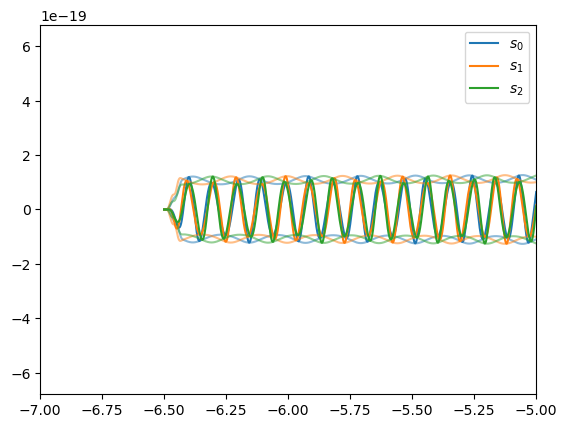

In [4]:
# Plot waveforms with envelopes
plt.plot(s_0.sample_times, s_0, c='C0', label='$s_0$')
plt.plot(s_0.sample_times, np.sqrt(s_0.real()**2 + s_0.imag()**2), c='C0', alpha=0.5)
plt.plot(s_0.sample_times, -np.sqrt(s_0.real()**2 + s_0.imag()**2), c='C0', alpha=0.5)
plt.plot(s_1.sample_times, s_1, c='C1', label='$s_1$')
plt.plot(s_1.sample_times, np.sqrt(s_1.real()**2 + s_1.imag()**2), c='C1', alpha=0.5)
plt.plot(s_1.sample_times, -np.sqrt(s_1.real()**2 + s_1.imag()**2), c='C1', alpha=0.5)
plt.plot(s_2.sample_times, s_2, c='C2', label='$s_2$')
plt.plot(s_2.sample_times, np.sqrt(s_2.real()**2 + s_2.imag()**2), c='C2', alpha=0.5)
plt.plot(s_2.sample_times, -np.sqrt(s_2.real()**2 + s_2.imag()**2), c='C2', alpha=0.5)
plt.legend()
plt.xlim(-7,-5)

Now check that normalisation has worked i.e. $(s_j|s_j)$ is equal for all $j$.

In [5]:
# Generate the aLIGO ZDHP PSD
psd, _ = gen_psd(s_0.real(), 10)

# Calculates (s_j|s_j) for j=0,1,2
s_0_sigma = sigmasq(s_0.real(), psd=psd, low_frequency_cutoff=10+3)
s_1_sigma = sigmasq(s_1.real(), psd=psd, low_frequency_cutoff=10+3)
s_2_sigma = sigmasq(s_2.real(), psd=psd, low_frequency_cutoff=10+3)

print(s_0_sigma, s_1_sigma, s_2_sigma)

1159346339.7885365 1159346339.7885365 1159346339.7885365


Now check whether $(s_0|s_1)=(s_2|s_0)=(s_1|s_2)$.

In [6]:
# Calculate (s_0|s_1), etc.
s0_s1 = overlap_cplx(s_0.real(), s_1.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)
s2_s0 = overlap_cplx(s_2.real(), s_0.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)
s1_s2 = overlap_cplx(s_1.real(), s_2.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)
s1_s0 = overlap_cplx(s_1.real(), s_0.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)
s0_s2 = overlap_cplx(s_0.real(), s_2.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)
s2_s1 = overlap_cplx(s_2.real(), s_1.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)

print(s0_s1, s2_s0, s1_s2)
print(s1_s0, s0_s2, s2_s1)
print(abs(s0_s1), abs(s2_s0), abs(s1_s2))
print(abs(s1_s0), abs(s0_s2), abs(s2_s1))
print(np.angle(s0_s1), np.angle(s2_s0), np.angle(s1_s2))
print(np.angle(s1_s0), np.angle(s0_s2), np.angle(s2_s1))

(0.9798203573564763+0.00019305891595991815j) (0.9780728052694694-0.00013485813755198376j) (0.9787440594338201+0.0302444199201819j)
(0.9798203573564762-0.00019305891595991652j) (0.9780728052694695+0.00013485813755198598j) (0.9787440594338201-0.030244419920181908j)
0.979820376376159 0.9780728145666899 0.9792112432020486
0.9798203763761589 0.97807281456669 0.9792112432020486
0.0001970350095423845 -0.0001378814910002729 0.03089142505323898
-0.00019703500954238286 0.00013788149100027518 -0.030891425053238986


These values are very close, although not exactly the same.

Let's build h0, h1, h2 for testing

In [7]:
# Find primitive root of unity
prim_root = np.e**(2j*np.pi/3)

# Build h0, h1, h2
hs = []
for i in range(3):
    hs.append((1/3)*(s_0 + prim_root**i * s_1 + prim_root**(2*i) * s_2))
h_0, h_1, h_2 = hs

In [8]:
# Get h0, h1 with n=2 for comparison
_, h_0_n2, h_1_n2, h_ap_n2, h_peri_n2 = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, approximant='TEOBResumS')

(-6.0, -5.0)

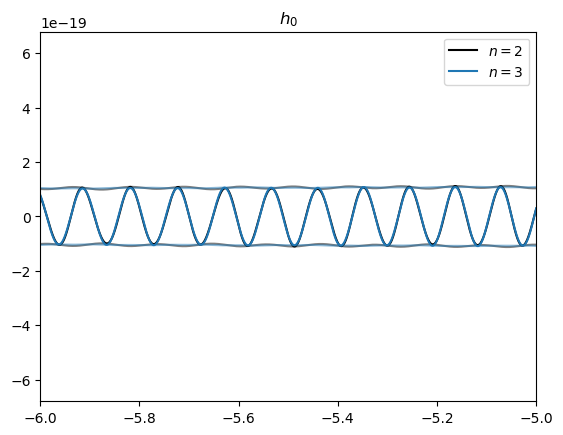

In [9]:
# Plot first waveform
plt.plot(h_0_n2.sample_times, h_0_n2, c='k', label='$n=2$')
plt.plot(h_0_n2.sample_times, np.sqrt(h_0_n2.real()**2 + h_0_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_0_n2.sample_times, -np.sqrt(h_0_n2.real()**2 + h_0_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_0.sample_times, h_0, c='C0', label='$n=3$')
plt.plot(h_0.sample_times, np.sqrt(h_0.real()**2 + h_0.imag()**2), c='C0', alpha=0.5)
plt.plot(h_0.sample_times, -np.sqrt(h_0.real()**2 + h_0.imag()**2), c='C0', alpha=0.5)
plt.title('$h_0$')
plt.legend()
plt.xlim(-6,-5)

(-6.0, -5.0)

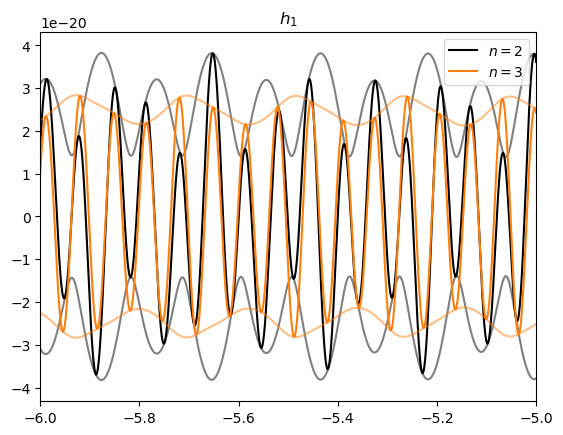

In [10]:
# Plot second waveform
plt.plot(h_1_n2.sample_times, h_1_n2, c='k', label='$n=2$')
plt.plot(h_1_n2.sample_times, np.sqrt(h_1_n2.real()**2 + h_1_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_1_n2.sample_times, -np.sqrt(h_1_n2.real()**2 + h_1_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_1.sample_times, h_1, c='C1', label='$n=3$')
plt.plot(h_1.sample_times, np.sqrt(h_1.real()**2 + h_1.imag()**2), c='C1', alpha=0.5)
plt.plot(h_1.sample_times, -np.sqrt(h_1.real()**2 + h_1.imag()**2), c='C1', alpha=0.5)
plt.title('$h_1$')
plt.legend()
plt.xlim(-6,-5)

(-6.0, -5.0)

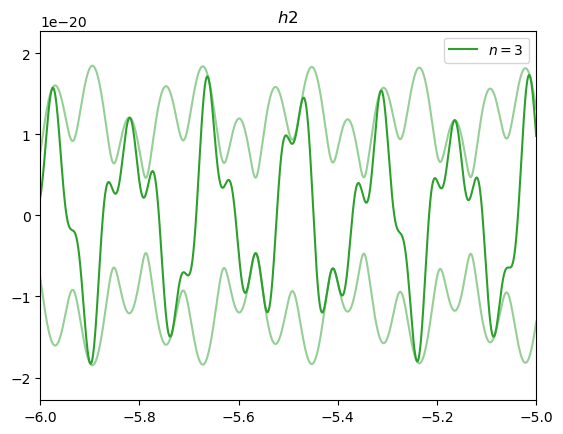

In [11]:
# Plot third waveform
plt.plot(h_2.sample_times, h_2, c='C2', label='$n=3$')
plt.plot(h_2.sample_times, np.sqrt(h_2.real()**2 + h_2.imag()**2), c='C2', alpha=0.5)
plt.plot(h_2.sample_times, -np.sqrt(h_2.real()**2 + h_2.imag()**2), c='C2', alpha=0.5)
plt.title('$h2$')
plt.legend()
plt.xlim(-6,-5)

In [12]:
# Generate the aLIGO ZDHP PSD
psd, _ = gen_psd(h_0.real(), 10)

# Calculates (h_j|h_j) for j=0,1,2
h_0_sigma = sigmasq(h_0.real(), psd=psd, low_frequency_cutoff=10+3)
h_1_sigma = sigmasq(h_1.real(), psd=psd, low_frequency_cutoff=10+3)
h_2_sigma = sigmasq(h_2.real(), psd=psd, low_frequency_cutoff=10+3)

print(h_0_sigma, h_1_sigma, h_2_sigma)

# Calculate (h_0|h_1), etc.
h0_h1 = abs(overlap_cplx(h_0.real(), h_1.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True))
h2_h0 = abs(overlap_cplx(h_2.real(), h_0.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True))
h1_h2 = abs(overlap_cplx(h_1.real(), h_2.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True))

print(h0_h1, h2_h0, h1_h2)

1143022027.6365712 14919998.893323299 1403602.8682814797
0.05079717443059228 0.16681760821253505 0.08580257106598878


The assumption that $(s_0|s_1) = (s_1|s_2) = (s_2|s_0)$ is slightly innaccurate, and this is leading to non-zero match values for $(h_j|h_m)$, $j\neq m$. To fix this, we will try to apply Grant-Schmidt orthogonalisation to force all $h_0, \ldots, h_{n-1}$ to be orthogonal.

# Grant-Schmidt orthogonalisation

Grant-Schmidt orthogonalisation works by making 2 or more vectors orthogonal to each other. Given vectors $v_1, \ldots, v_n$ which are not orthogonal are used to create vectors $u_1, \ldots, u_n$ which are. First define the vector projection $\mathrm{proj}_u(v)$ as:

$$
\mathrm{proj}_u(v) = \frac{\langle v,u\rangle}{\langle u,u\rangle}u
$$

We then construct $u_1,...,u_n$ as follows:

$$
u_1 = v_1
$$

$$
u_2 = v_2 - \mathrm{proj}_{u_1}(v_2)
$$

$$
u_3 = v_3 - \mathrm{proj}_{u_1}(v_3) - \mathrm{proj}_{u_2}(v_3)
$$

etc.

$$
u_k = v_k - \sum_{j=1}^{k-1} \mathrm{proj}_{u_j}(v_k)
$$

The application to our case is obvious. We can define $h_j^\perp$ as $u_j$ above, and $h_j$ as $v_j$. To then calculate $h_1^\perp$, we have

$$
h_1^\perp = h_1 - \frac{(h_1| h_0)}{(h_0|h_0)} h_0
$$

Now taking the 'dot-product' with $h_0$ (= $h_0^\perp$), we get

$$
(h_1^\perp|h_0^\perp) = (h_1|h_0) - \frac{(h_1| h_0)}{(h_0|h_0)} (h_0|h_0)
$$

$$
(h_1^\perp|h_0^\perp) = (h_1|h_0) - (h_1| h_0) = 0
$$

Taking this product the other way around gives us

$$
(h_0^\perp|h_1^\perp) = (h_0|h_1) - \left(\frac{(h_1| h_0)}{(h_0|h_0)}\right)^* (h_0|h_0)
$$

$$
(h_0^\perp|h_1^\perp) = (h_0|h_1) - (h_0| h_1) = 0
$$

using the fact that $(a|b) = {(b|a)}^*$.

We can then easily extend this to create $h_2^\perp, \ldots, h_{n-1}^\perp$. Using this we should no longer need the normalisation $\hat{s}_j = s_j \sqrt{(s_0|s_0)}/\sqrt{(s_j|s_j)}$, and so will drop it from now on. We will now create $h_0, h_1, h_2$ for $n=3$ using this process (dropping the $\perp$ superscript now for ease of notation), and test that they are indeed orthogonal.

In [13]:
s_0, s_1, s_2 = gen_component_wfs(10, 0.1, chirp2total(24,2), 2, 3, 4096, 'TEOBResumS', False, True)

(-7.0, -5.0)

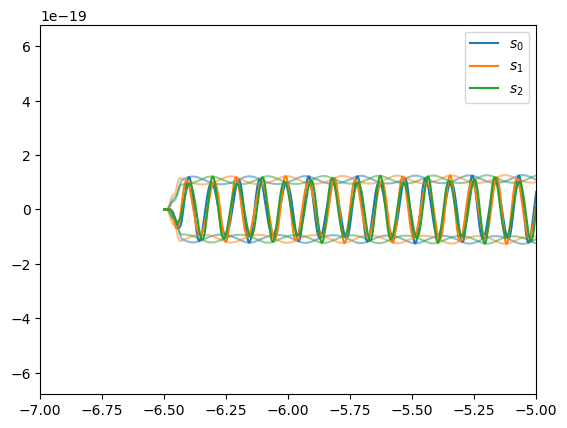

In [14]:
# Plot waveforms with envelopes
plt.plot(s_0.sample_times, s_0, c='C0', label='$s_0$')
plt.plot(s_0.sample_times, np.sqrt(s_0.real()**2 + s_0.imag()**2), c='C0', alpha=0.5)
plt.plot(s_0.sample_times, -np.sqrt(s_0.real()**2 + s_0.imag()**2), c='C0', alpha=0.5)
plt.plot(s_1.sample_times, s_1, c='C1', label='$s_1$')
plt.plot(s_1.sample_times, np.sqrt(s_1.real()**2 + s_1.imag()**2), c='C1', alpha=0.5)
plt.plot(s_1.sample_times, -np.sqrt(s_1.real()**2 + s_1.imag()**2), c='C1', alpha=0.5)
plt.plot(s_2.sample_times, s_2, c='C2', label='$s_2$')
plt.plot(s_2.sample_times, np.sqrt(s_2.real()**2 + s_2.imag()**2), c='C2', alpha=0.5)
plt.plot(s_2.sample_times, -np.sqrt(s_2.real()**2 + s_2.imag()**2), c='C2', alpha=0.5)
plt.legend()
plt.xlim(-7,-5)

In [15]:
# Generate the aLIGO ZDHP PSD
psd, _ = gen_psd(s_0.real(), 10)

# Calculates (s_j|s_j) for j=0,1,2
s_0_sigma = sigmasq(s_0.real(), psd=psd, low_frequency_cutoff=10+3)
s_1_sigma = sigmasq(s_1.real(), psd=psd, low_frequency_cutoff=10+3)
s_2_sigma = sigmasq(s_2.real(), psd=psd, low_frequency_cutoff=10+3)

print(s_0_sigma, s_1_sigma, s_2_sigma)

1159346339.7885368 1159521237.5723386 1162195856.8854854


In [16]:
# Calculate (s_0|s_1), etc.
s0_s1 = overlap_cplx(s_0.real(), s_1.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)
s2_s0 = overlap_cplx(s_2.real(), s_0.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)
s1_s2 = overlap_cplx(s_1.real(), s_2.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)
s1_s0 = overlap_cplx(s_1.real(), s_0.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)
s0_s2 = overlap_cplx(s_0.real(), s_2.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)
s2_s1 = overlap_cplx(s_2.real(), s_1.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True)

print(s0_s1, s2_s0, s1_s2)
print(s1_s0, s0_s2, s2_s1)
print(abs(s0_s1), abs(s2_s0), abs(s1_s2))
print(abs(s1_s0), abs(s0_s2), abs(s2_s1))
print(np.angle(s0_s1), np.angle(s2_s0), np.angle(s1_s2))
print(np.angle(s1_s0), np.angle(s0_s2), np.angle(s2_s1))

(0.9798203573564763+0.00019305891595991086j) (0.9780728052694694-0.00013485813755198552j) (0.9787440594338203+0.030244419920181894j)
(0.9798203573564765-0.0001930589159599138j) (0.9780728052694692+0.00013485813755198411j) (0.9787440594338199-0.030244419920181898j)
0.979820376376159 0.9780728145666899 0.9792112432020487
0.9798203763761593 0.9780728145666897 0.9792112432020483
0.00019703500954237706 -0.00013788149100027472 0.030891425053238972
-0.00019703500954238002 0.0001378814910002733 -0.030891425053238983


Let's build h0, h1, h2 for testing

In [17]:
# Projection operator used in GS orthogonalisation
def GS_proj(u, v):

    numerator = overlap_cplx(v.real(), u.real(), psd=psd, low_frequency_cutoff=10+3, normalized=False)
    denominator = overlap_cplx(u.real(), u.real(), psd=psd, low_frequency_cutoff=10+3, normalized=False)

    return u*numerator/denominator

In [18]:
# Find primitive root of unity
prim_root = np.e**(2j*np.pi/3)

# Build h0, h1, h2
hs = []
for i in range(3):
    hs.append((1/3)*(s_0 + prim_root**i * s_1 + prim_root**(2*i) * s_2))

# Applies GS orthogonalisation
for i in range(1,3):
    for j in range(i):
        hs[i] = hs[i] - GS_proj(hs[j], hs[i])
h_0, h_1, h_2 = hs

In [19]:
# Get h0, h1 with n=2 for comparison
_, h_0_n2, h_1_n2, h_ap_n2, h_peri_n2 = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, approximant='TEOBResumS')

(-6.0, -5.0)

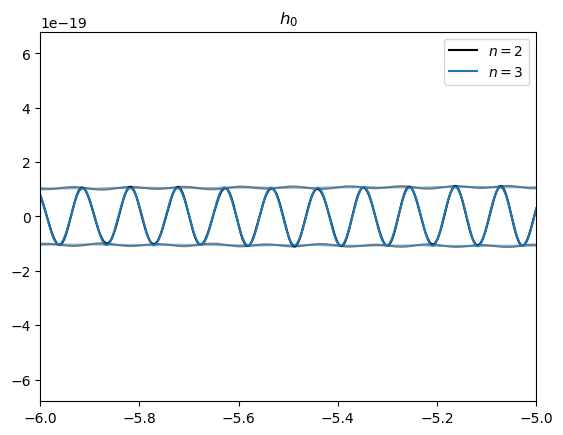

In [20]:
# Plot first waveform
plt.plot(h_0_n2.sample_times, h_0_n2, c='k', label='$n=2$')
plt.plot(h_0_n2.sample_times, np.sqrt(h_0_n2.real()**2 + h_0_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_0_n2.sample_times, -np.sqrt(h_0_n2.real()**2 + h_0_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_0.sample_times, h_0, c='C0', label='$n=3$')
plt.plot(h_0.sample_times, np.sqrt(h_0.real()**2 + h_0.imag()**2), c='C0', alpha=0.5)
plt.plot(h_0.sample_times, -np.sqrt(h_0.real()**2 + h_0.imag()**2), c='C0', alpha=0.5)
plt.title('$h_0$')
plt.legend()
plt.xlim(-6,-5)

(-6.0, -5.0)

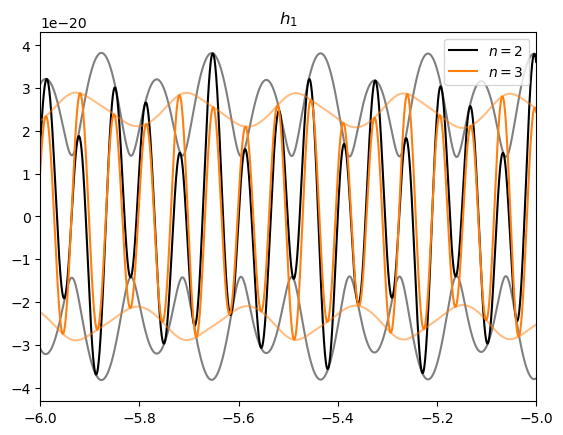

In [21]:
# Plot second waveform
plt.plot(h_1_n2.sample_times, h_1_n2, c='k', label='$n=2$')
plt.plot(h_1_n2.sample_times, np.sqrt(h_1_n2.real()**2 + h_1_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_1_n2.sample_times, -np.sqrt(h_1_n2.real()**2 + h_1_n2.imag()**2), c='k', alpha=0.5)
plt.plot(h_1.sample_times, h_1, c='C1', label='$n=3$')
plt.plot(h_1.sample_times, np.sqrt(h_1.real()**2 + h_1.imag()**2), c='C1', alpha=0.5)
plt.plot(h_1.sample_times, -np.sqrt(h_1.real()**2 + h_1.imag()**2), c='C1', alpha=0.5)
plt.title('$h_1$')
plt.legend()
plt.xlim(-6,-5)

(-6.0, -5.0)

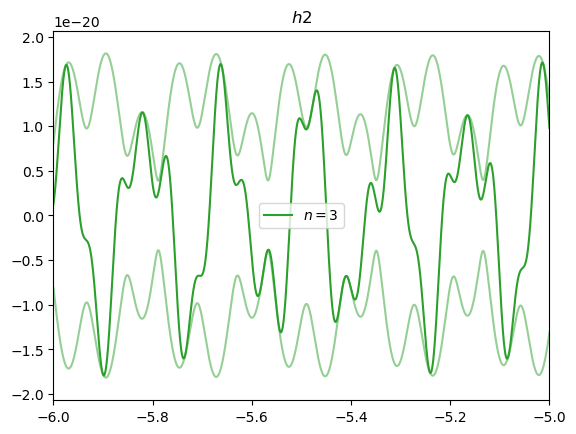

In [22]:
# Plot third waveform
plt.plot(h_2.sample_times, h_2, c='C2', label='$n=3$')
plt.plot(h_2.sample_times, np.sqrt(h_2.real()**2 + h_2.imag()**2), c='C2', alpha=0.5)
plt.plot(h_2.sample_times, -np.sqrt(h_2.real()**2 + h_2.imag()**2), c='C2', alpha=0.5)
plt.title('$h2$')
plt.legend()
plt.xlim(-6,-5)

Plots have not significantly changed.

In [23]:
# Generate the aLIGO ZDHP PSD
psd, _ = gen_psd(h_0.real(), 10)

# Calculates (h_j|h_j) for j=0,1,2
h_0_sigma = sigmasq(h_0.real(), psd=psd, low_frequency_cutoff=10+3)
h_1_sigma = sigmasq(h_1.real(), psd=psd, low_frequency_cutoff=10+3)
h_2_sigma = sigmasq(h_2.real(), psd=psd, low_frequency_cutoff=10+3)

print(h_0_sigma, h_1_sigma, h_2_sigma)

# Calculate (h_0|h_1), etc.
h0_h1 = abs(overlap_cplx(h_0.real(), h_1.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True))
h2_h0 = abs(overlap_cplx(h_2.real(), h_0.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True))
h1_h2 = abs(overlap_cplx(h_1.real(), h_2.real(), psd=psd, low_frequency_cutoff=10+3, normalized=True))

print(h0_h1, h2_h0, h1_h2)

1144015330.0623856 14894657.31076851 1355770.1641081579
3.3316137735007545e-07 5.152366371064696e-05 2.0657145268687557e-05


$h_0, \ldots, h_{n-1}$ are orthogonal now!

# Testing generalised get_h()

First test just with $n=2$ to make sure it still works

In [24]:
h, h1, h2, h_ap, h_peri = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, approximant='TEOBResumS')

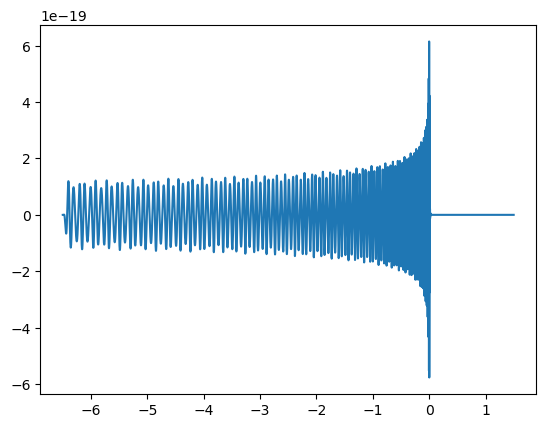

In [25]:
plt.plot(h.sample_times, h)

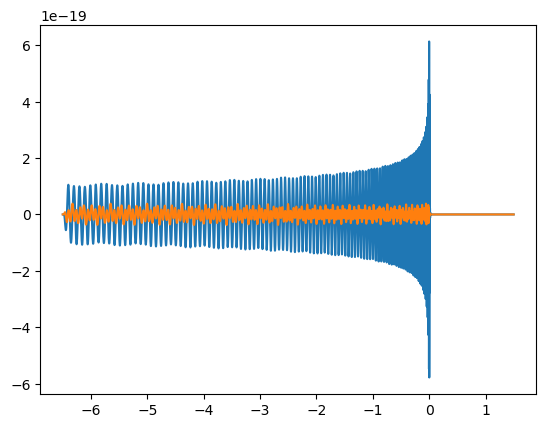

In [26]:
plt.plot(h.sample_times, h1)
plt.plot(h.sample_times, h2)

(-6.0, -4.0)

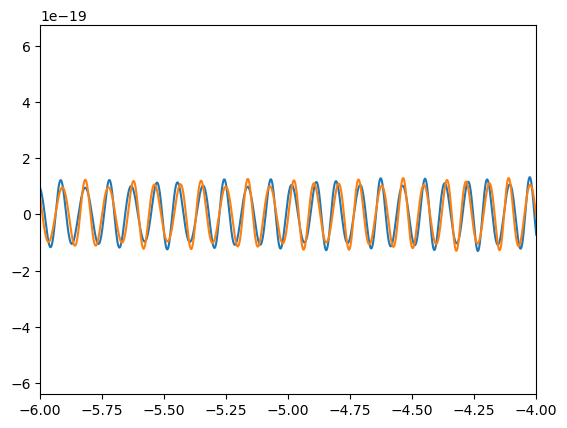

In [27]:
plt.plot(h.sample_times, h_ap)
plt.plot(h.sample_times, h_peri)
plt.xlim(-6,-4)

All plots look sensible! Nothing is clearly broken.

Now move on to $n=3$ case. Note that the number of TEOB calls required is equal to $2n-1$.

In [28]:
h, h1, h2, h3, s1, s2, s3 = get_h([1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, approximant='TEOBResumS')

(-6.0, -5.0)

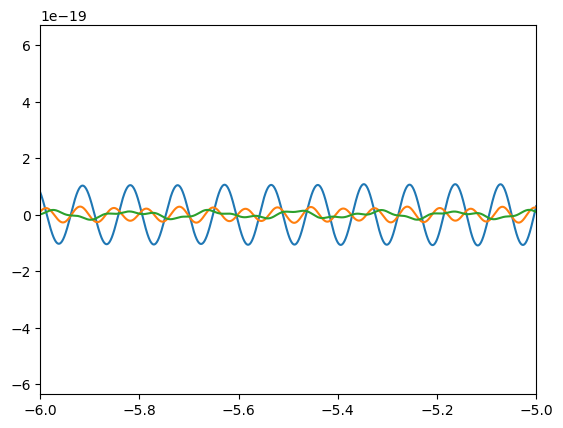

In [29]:
plt.plot(h1.sample_times, h1)
plt.plot(h2.sample_times, h2)
plt.plot(h3.sample_times, h3)
plt.xlim(-6,-5)

(-6.0, -4.0)

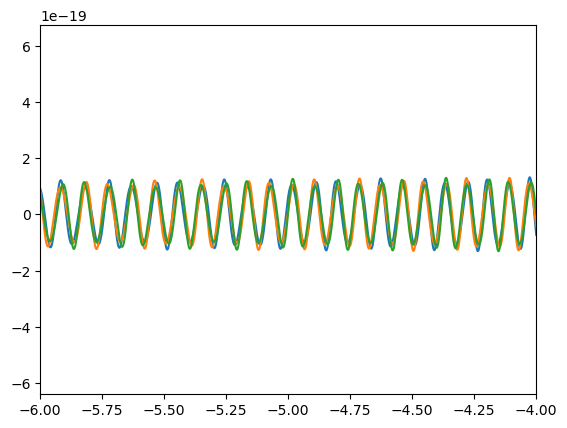

In [30]:
plt.plot(h.sample_times, s1)
plt.plot(h.sample_times, s2)
plt.plot(h.sample_times, s3)
plt.xlim(-6,-4)

Once again seems sensible. Try $n=6$ to test high $n$.

In [63]:
h, h1, h2, h3, h4, h5, h6, s1, s2, s3, s4, s5, s6 = get_h([1,1,1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, approximant='TEOBResumS', comp_normalisation=True)

(-5.0, -4.0)

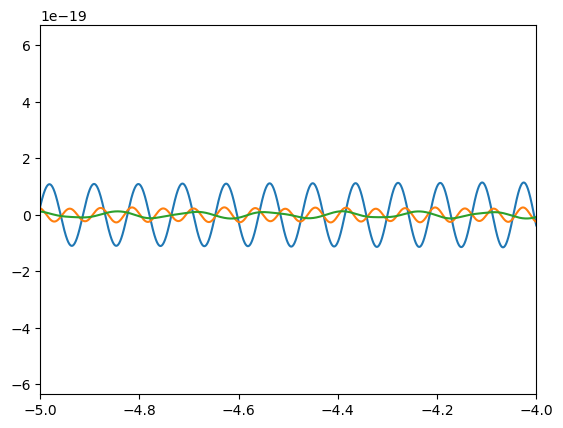

In [66]:
plt.plot(h.sample_times, h1)
plt.plot(h.sample_times, h2)
plt.plot(h.sample_times, h3)
# plt.plot(h.sample_times, h4)
# plt.plot(h.sample_times, h5)
# plt.plot(h.sample_times, h6)
plt.xlim(-5,-4)

(-6.0, -4.0)

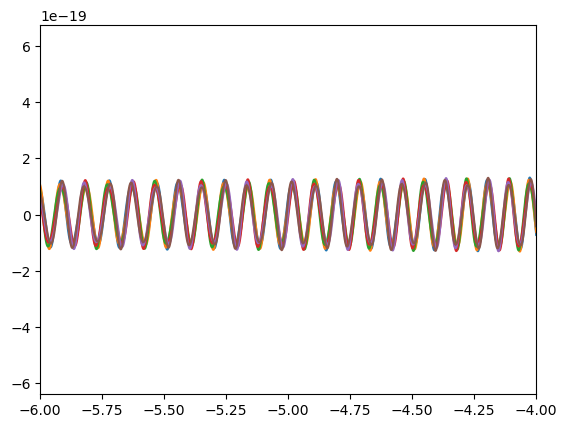

In [33]:
plt.plot(h.sample_times, s1)
plt.plot(h.sample_times, s2)
plt.plot(h.sample_times, s3)
plt.plot(h.sample_times, s4)
plt.plot(h.sample_times, s5)
plt.plot(h.sample_times, s6)
plt.xlim(-6,-4)

Seems to work here as well! Let's do a quick check of orthogonality.

In [34]:
psd, _ = gen_psd(h1.real(), 10)

h1_h1 = abs(overlap_cplx(h1.real(), h1.real(), psd=psd, low_frequency_cutoff=10+3))
h1_h2 = abs(overlap_cplx(h1.real(), h2.real(), psd=psd, low_frequency_cutoff=10+3))
h1_h3 = abs(overlap_cplx(h1.real(), h3.real(), psd=psd, low_frequency_cutoff=10+3))
h1_h4 = abs(overlap_cplx(h1.real(), h4.real(), psd=psd, low_frequency_cutoff=10+3))
h1_h5 = abs(overlap_cplx(h1.real(), h5.real(), psd=psd, low_frequency_cutoff=10+3))
h1_h6 = abs(overlap_cplx(h1.real(), h6.real(), psd=psd, low_frequency_cutoff=10+3))

print(h1_h1, h1_h2, h1_h3, h1_h4, h1_h5, h1_h6)

1.0000000000000002 1.264750215153185e-07 1.2909660432143287e-05 0.00046783938358957704 0.0003646798216315253 0.010384207241559765


Let's take a fourier transform of h1,...,h5. Generate long signal using lower starting frequency and total mass, and only take first 8 seconds in order to get roughly constant frequency across timeseries we fourier transform.

In [35]:
_, h1, h2, h3, h4, h5, s1, s2, s3, s4, s5 = get_h([1,1,1,1,1], 5, 0.1, 30, 2, 4096, approximant='TEOBResumS')
h1_f = make_frequency_series(h1.real()[0:4096*8])
h2_f = make_frequency_series(h2.real()[0:4096*8])
h3_f = make_frequency_series(h3.real()[0:4096*8])
h4_f = make_frequency_series(h4.real()[0:4096*8])
h5_f = make_frequency_series(h5.real()[0:4096*8])

(-10.0, 20.0)

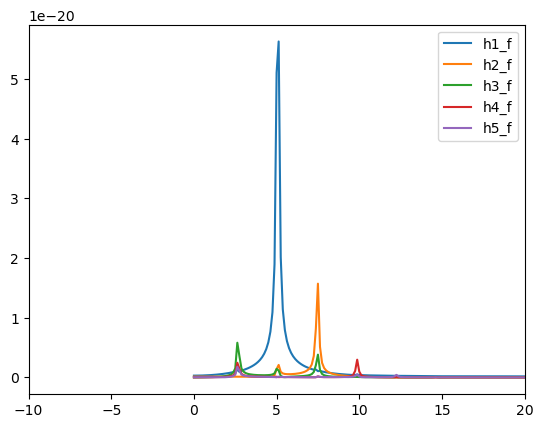

In [36]:
plt.plot(h1_f.sample_frequencies, abs(h1_f), label='h1_f')
plt.plot(h2_f.sample_frequencies, abs(h2_f), label='h2_f')
plt.plot(h3_f.sample_frequencies, abs(h3_f), label='h3_f')
plt.plot(h4_f.sample_frequencies, abs(h4_f), label='h4_f')
plt.plot(h5_f.sample_frequencies, abs(h5_f), label='h5_f')
plt.legend()
plt.xlim(-10,20)

In [60]:
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, approximant='TEOBResumS', comp_normalisation=False)

In [61]:
# Generate the aLIGO ZDHP PSD
psd, high_frequency_cutoff = gen_psd(h1.real(), 10)

# Calculates (h_j|h_j) for j=1,2,3,4
h1_sigma = sigmasq(h1.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff)
h2_sigma = sigmasq(h2.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff)
h3_sigma = sigmasq(h3.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff)
h4_sigma = sigmasq(h4.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff)

#print(h1_sigma, h2_sigma, h3_sigma, h4_sigma, format='{:.2g}')
print('{:.2g}'.format(h1_sigma))
print('{:.2g}'.format(h2_sigma))
print('{:.2g}'.format(h3_sigma))
print('{:.2g}'.format(h4_sigma))


# Calculate (h_0|h_1), etc.
h1_h2 = abs(overlap_cplx(h1.real(), h2.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))
h2_h3 = abs(overlap_cplx(h2.real(), h3.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))
h3_h4 = abs(overlap_cplx(h3.real(), h4.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))
h4_h1 = abs(overlap_cplx(h4.real(), h1.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))
h1_h3 = abs(overlap_cplx(h1.real(), h3.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))
h2_h4 = abs(overlap_cplx(h2.real(), h4.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))

print(h1_h2, h2_h3, h3_h4, h4_h1)
print(h1_h3, h2_h4)

1.1e+09
1.5e+07
1.4e+06
5.2e+05
6.473385967561447e-07 1.697252194284378e-05 0.012191192291487386 0.0003574378329999142
1.8004987538742496e-06 0.0033480494337424864


In [39]:
_, h1, h2, h3, h4, s1, s2, s3, s4 = get_h([1,1,1,1], 10, 0.1, chirp2total(24, 2), 2, 4096, approximant='TEOBResumS', comp_normalisation=True)

In [40]:
# Generate the aLIGO ZDHP PSD
psd, high_frequency_cutoff = gen_psd(h1.real(), 10)

# Calculates (h_j|h_j) for j=1,2,3,4
h1_sigma = sigmasq(h1.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff)
h2_sigma = sigmasq(h2.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff)
h3_sigma = sigmasq(h3.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff)
h4_sigma = sigmasq(h4.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff)

print(h1_sigma, h2_sigma, h3_sigma, h4_sigma)

# Calculate (h_0|h_1), etc.
h1_h2 = abs(overlap_cplx(h1.real(), h2.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))
h2_h3 = abs(overlap_cplx(h2.real(), h3.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))
h3_h4 = abs(overlap_cplx(h3.real(), h4.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))
h4_h1 = abs(overlap_cplx(h4.real(), h1.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))
h1_h3 = abs(overlap_cplx(h1.real(), h3.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))
h2_h4 = abs(overlap_cplx(h2.real(), h4.real(), psd=psd, low_frequency_cutoff=10+3, high_frequency_cutoff=high_frequency_cutoff))

print(h1_h2, h2_h3, h3_h4, h4_h1)
print(h1_h3, h2_h4)

1142213839.1271653 15216170.685893983 1347041.2016103663 433678.25166274817
1.671345922326825e-07 3.0997595316620886e-06 0.0006598043269899483 0.000284993846336563
1.483593538214673e-06 0.0003873350220802468


# Fourier transforms

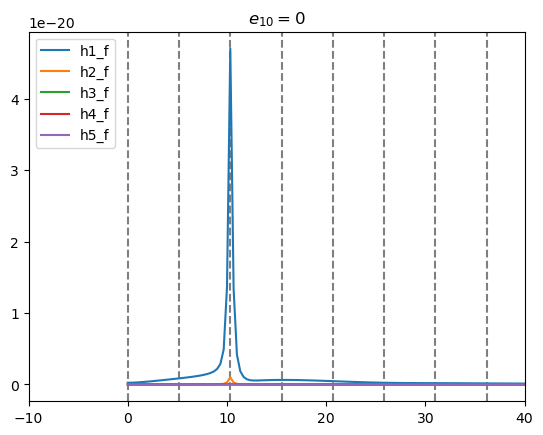

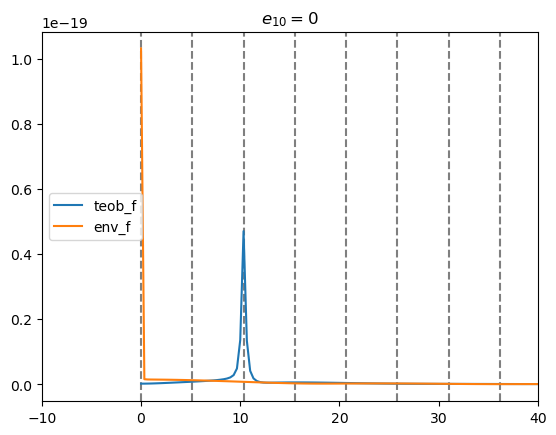

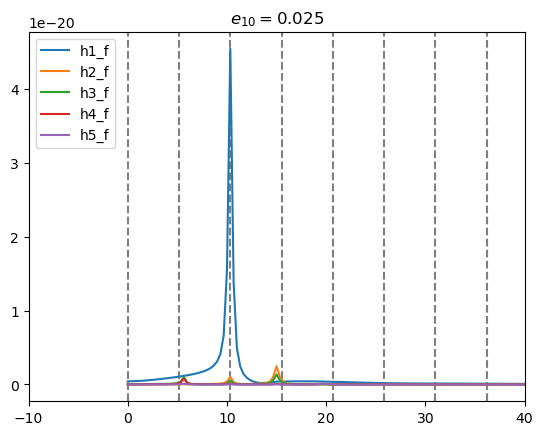

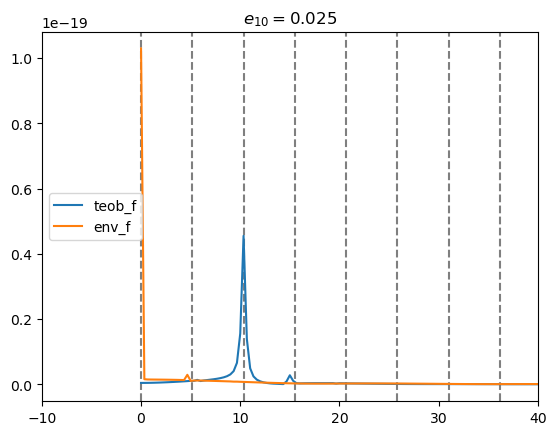

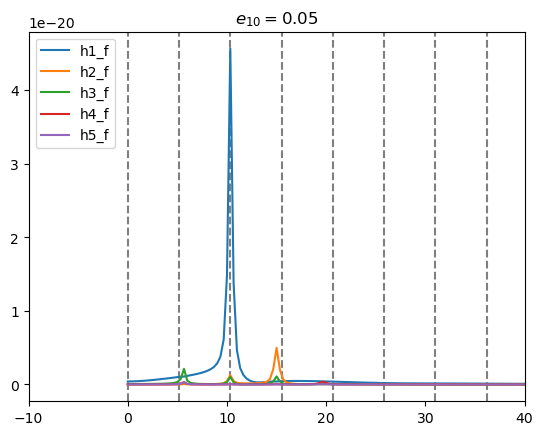

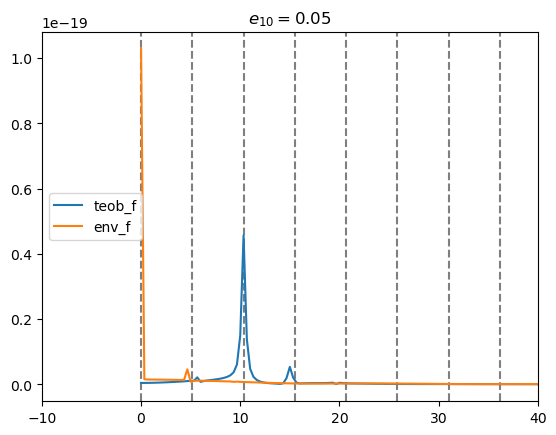

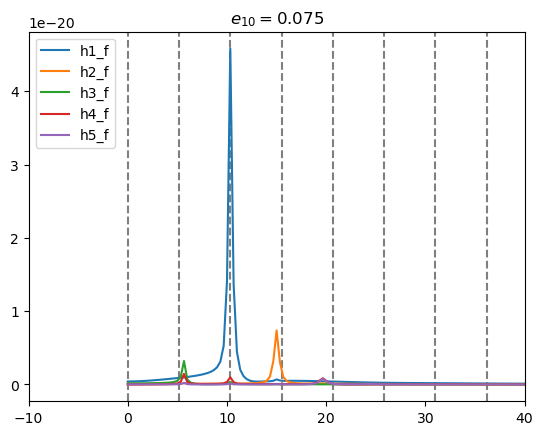

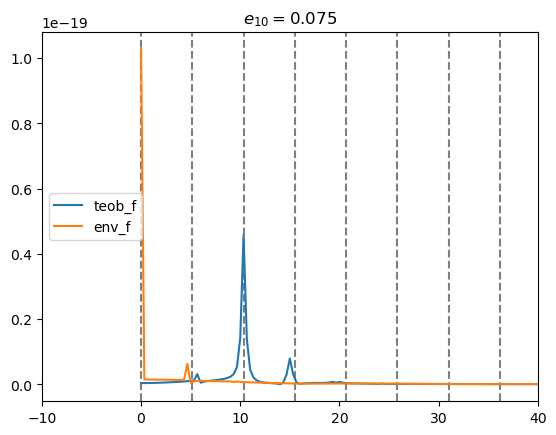

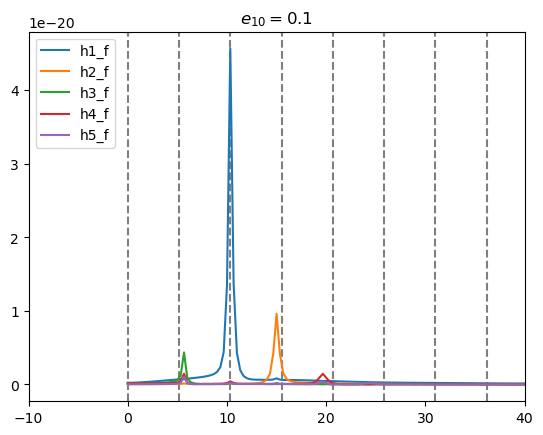

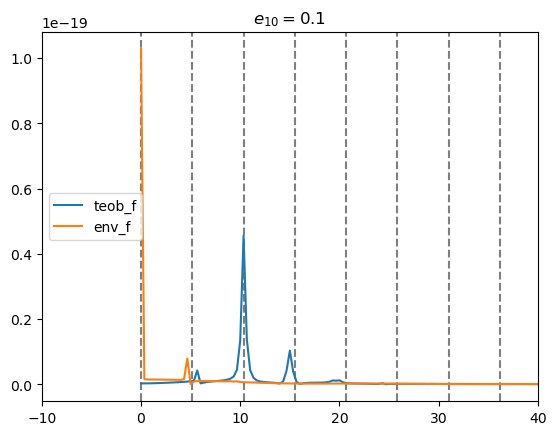

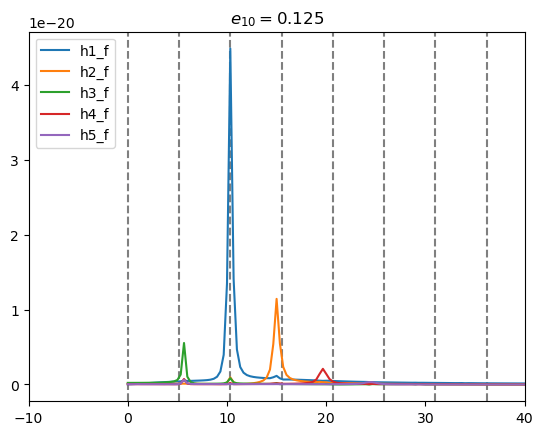

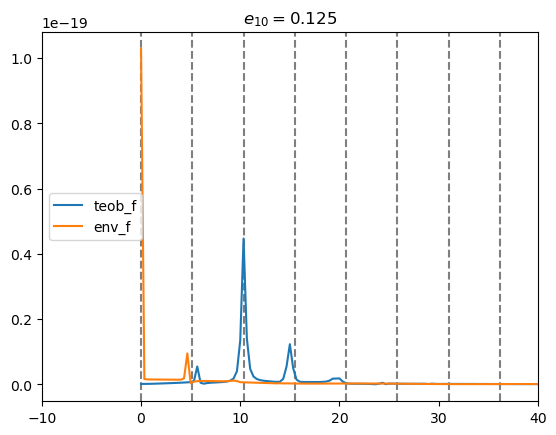

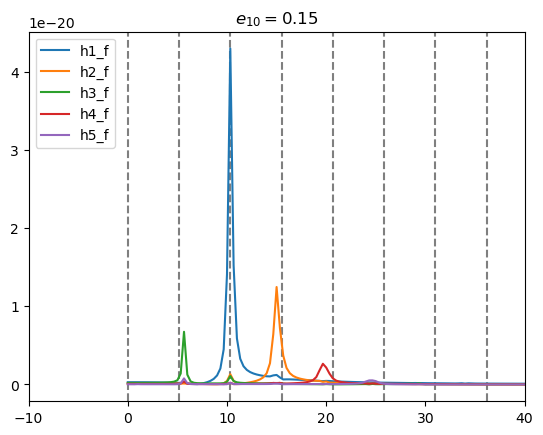

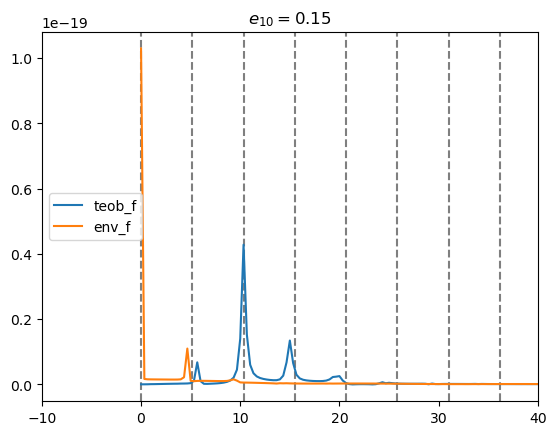

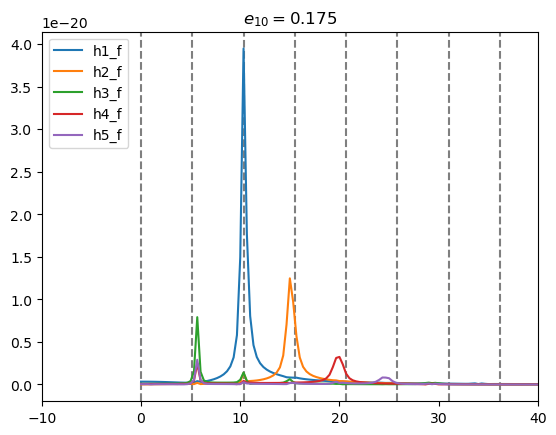

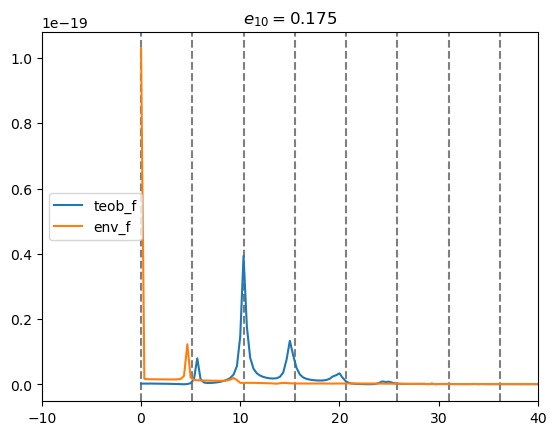

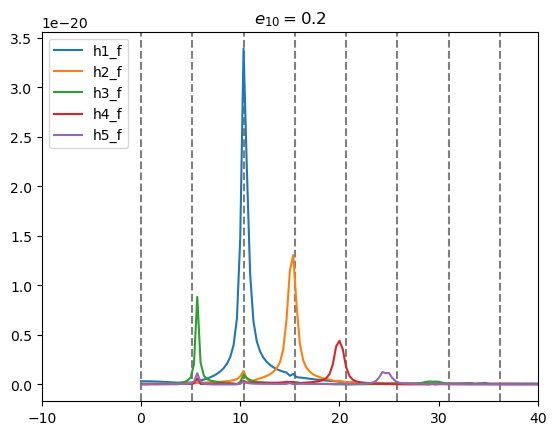

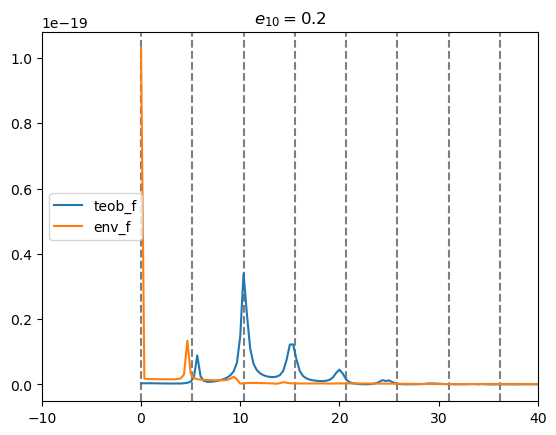

In [183]:
# Loop over all eccentricities
n1_peaks = []
n2_peaks = []
n3_peaks = []
env_peaks = []
for e in [0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2]:

    # Create and FT waveforms
    _, h1, h2, h3, h4, h5, s1, s2, s3, s4, s5 = get_h([1,1,1,1,1], 10, e, 30, 2, 4096, approximant='TEOBResumS')
    h1_f = make_frequency_series(h1.real()[0:4096*3])
    h2_f = make_frequency_series(h2.real()[0:4096*3])
    h3_f = make_frequency_series(h3.real()[0:4096*3])
    h4_f = make_frequency_series(h4.real()[0:4096*3])
    h5_f = make_frequency_series(h5.real()[0:4096*3])
    teob_f = make_frequency_series(s1.real()[0:4096*3])
    env_f = make_frequency_series(np.sqrt(s1.real()[0:4096*3]**2 + s1.imag()[0:4096*3]**2))

    # # Interpolate FT results to increase frequency resolution
    # interp_fs = np.linspace(0, 40, 40001)
    # wfs_f = [h1_f, h2_f, h3_f, h4_f, h5_f, teob_f, env_f]
    # for i in range(len(wfs_f)):
    #     wf_f_interpolate = interp1d(wfs_f[i].sample_frequencies, abs(wfs_f[i]), kind='quadratic', bounds_error=False, fill_value=0)
    #     wf_f_strain = wf_f_interpolate(interp_fs)
    #     wfs_f[i] = frequencyseries.FrequencySeries(wf_f_strain, np.mean(np.diff(interp_fs)))
    # h1_f, h2_f, h3_f, h4_f, h5_f, teob_f, env_f = wfs_f

    # Find location of peak modes
    n2_peak_arg = np.argmax(abs(teob_f)) # Assumes n=2 is largest for all eccentricities considered
    n2_peak = teob_f.sample_frequencies[n2_peak_arg]
    n1_range = [int(0.25*n2_peak_arg), int(0.75*n2_peak_arg)]
    n1_peak = teob_f.sample_frequencies[n1_range[0]+np.argmax(abs(teob_f[n1_range[0]:n1_range[1]]))]
    n3_range = [int(1.25*n2_peak_arg), int(1.75*n2_peak_arg)]
    n3_peak = teob_f.sample_frequencies[n3_range[0]+np.argmax(abs(teob_f[n3_range[0]:n3_range[1]]))]
    env_peak = env_f.sample_frequencies[3+np.argmax(abs(env_f[3:]))]
    n1_peaks.append(n1_peak)
    n2_peaks.append(n2_peak)
    n3_peaks.append(n3_peak)
    env_peaks.append(env_peak)

    # Make h1,...,h5 plot
    plt.plot(h1_f.sample_frequencies, abs(h1_f), label='h1_f')
    plt.plot(h2_f.sample_frequencies, abs(h2_f), label='h2_f')
    plt.plot(h3_f.sample_frequencies, abs(h3_f), label='h3_f')
    plt.plot(h4_f.sample_frequencies, abs(h4_f), label='h4_f')
    plt.plot(h5_f.sample_frequencies, abs(h5_f), label='h5_f')
    for mode in range(10):
        plt.axvline(mode*n2_peak/2, ls='dashed', c='k', alpha=0.5, zorder=-1)
    plt.title('$e_{10} = $'+str(e))
    plt.legend()
    plt.xlim(-10,40)
    plt.show()

    # Make teob plot
    plt.plot(teob_f.sample_frequencies, abs(teob_f), label='teob_f')
    plt.plot(env_f.sample_frequencies, abs(env_f), label='env_f')
    for mode in range(10):
        plt.axvline(mode*n2_peak/2, ls='dashed', c='k', alpha=0.5, zorder=-1)
    plt.title('$e_{10} = $'+str(e))
    plt.legend()
    plt.xlim(-10,40)
    plt.show()

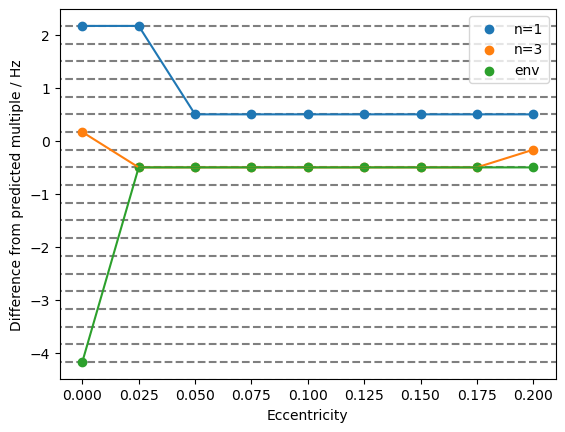

In [184]:
plt.scatter([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2], np.array(n1_peaks)-np.array(n2_peaks)/2, label='n=1')
plt.scatter([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2], np.array(n3_peaks)-3*np.array(n2_peaks)/2, label='n=3')
plt.scatter([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2], np.array(env_peaks)-np.array(n2_peaks)/2, label='env')
plt.plot([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2], np.array(n1_peaks)-np.array(n2_peaks)/2)
plt.plot([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2], np.array(n3_peaks)-3*np.array(n2_peaks)/2)
plt.plot([0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2], np.array(env_peaks)-np.array(n2_peaks)/2)
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()
plt.hlines(np.arange(-33/6, 33/6, 1/3),-1,1,zorder=-1,colors='k',alpha=0.5,ls='dashed')
plt.ylim(ylims)
plt.xlim(xlims)
plt.xlabel('Eccentricity')
plt.ylabel('Difference from predicted multiple / Hz')
plt.legend()

We expect the above difference to scale with the rate of periastron advance, given per orbit as:

$$
\Delta \phi = \frac{2\pi}{P} \frac{3G}{c^2} \frac{m_1+m_2}{a(1-e^2)}
$$

Both $P$ and $a$ can be expressed as frequencies using $f_{orb}=1/P$ and Kepler's 3rd law:

$$
\frac{1}{f_{orb}^2} = \left(\frac{4\pi^2}{GM}\right)a^3
$$

$$
a = \sqrt[3]{\frac{1}{f_{orb}^2}\left(\frac{GM}{4\pi^2}\right)}
$$

This gives:

$$
\Delta \phi = 2\pi f_{orb} \frac{3G}{c^2} \frac{m_1+m_2}{(1-e^2)} \frac{(2\pi f_{orb})^{2/3}}{(GM)^{1/3}}
$$

$$
\Delta \phi = \frac{3(GM)^{2/3}}{c^2} \frac{(2\pi f_{orb})^{5/3}}{(1-e^2)}
$$

If we then e.g. halve the starting frequency, this would decrease the size of the effect by $2^{5/3} = 3.17$. We would therefore need to take ~3 times as many seconds from the start of the waveform to  "keep pace" relatively speaking with frequency resolution, and would require even more time to see any improvement. We can also decrease the total mass from 30 to 20, roughly doubling the length of the signal at the cost of a factor ~1.3 reduction if effect size.

Current peaks show differences of 0.5 Hz with a frequency resolution (delta f) of 0.33 Hz. Assuming the first value here to be exactly correct, we would require a delta f of $1/(1-e^2)-1$ Hz to see any difference at an eccentricity $e$. This corresponds to 0.04 Hz at $e = 0.2$, or 0.19 Hz at $e=0.4$. Let's try $e_5=0.3$, and increase the time taken from the start until the fourier transform breaks down.

-193.624023438


(-5.0, 20.0)

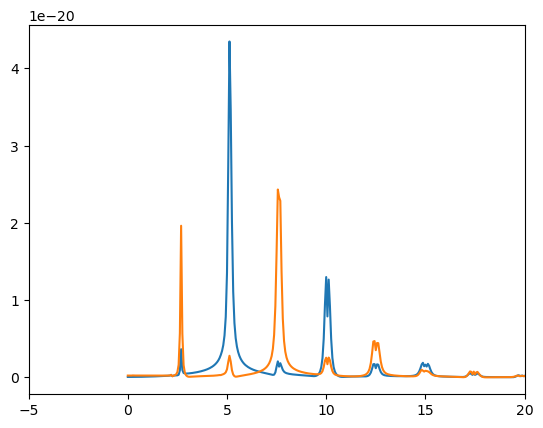

In [3]:
# Create and FT waveforms
_, h1, h2, s1, s2 = get_h([1,1], 5, 0.3, 20, 2, 4096, approximant='TEOBResumS')
print(h1.sample_times[0])
h1_f = make_frequency_series(h1.real()[0:4096*16])
h2_f = make_frequency_series(h2.real()[0:4096*16])

# Make h1,h2 plot
plt.plot(h1_f.sample_frequencies, abs(h1_f), label='h1_f')
plt.plot(h2_f.sample_frequencies, abs(h2_f), label='h2_f')
plt.xlim(-5,20)

Appears 16 seconds is the limit, so let's try this.

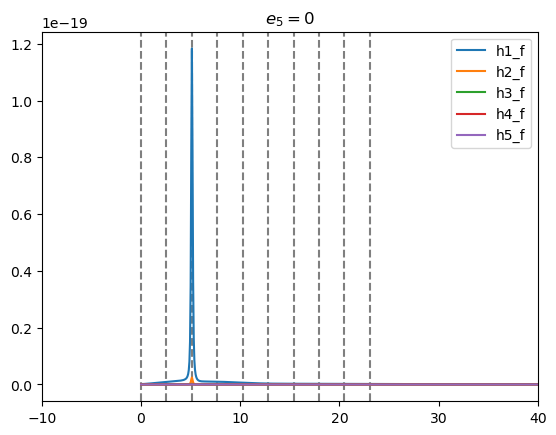

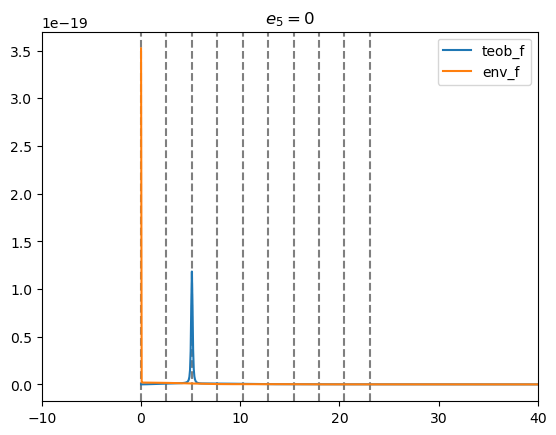

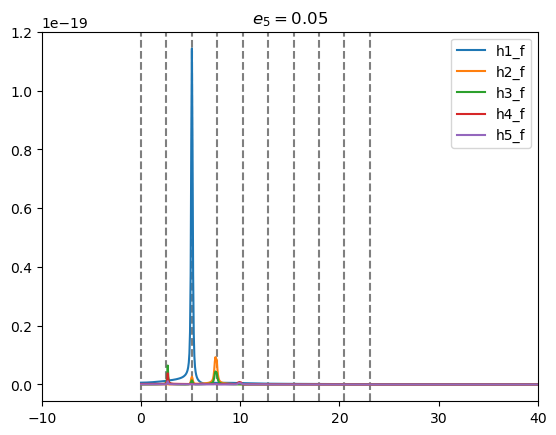

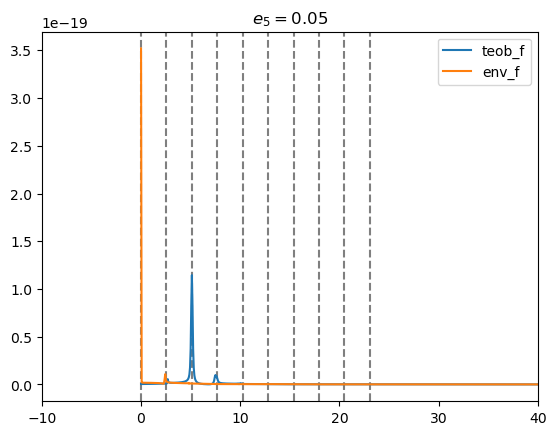

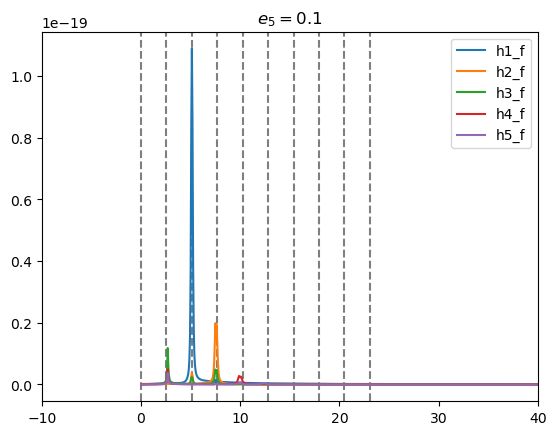

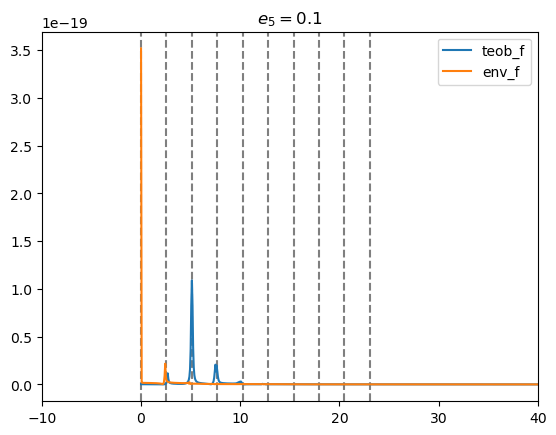

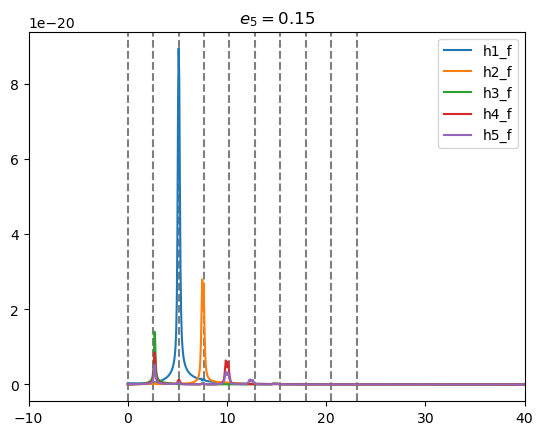

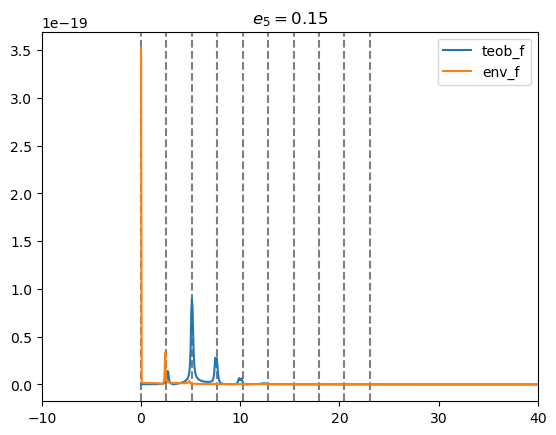

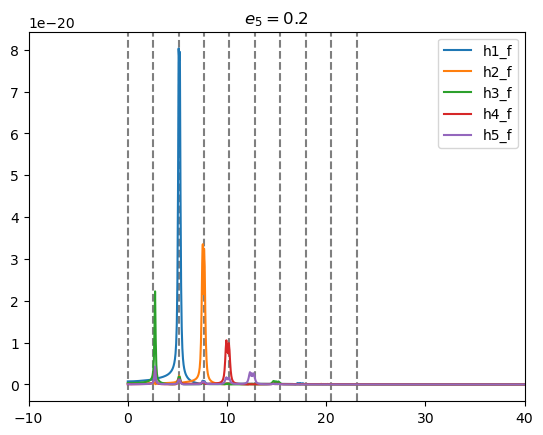

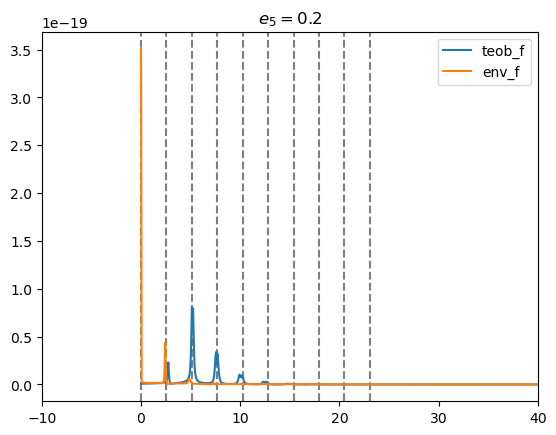

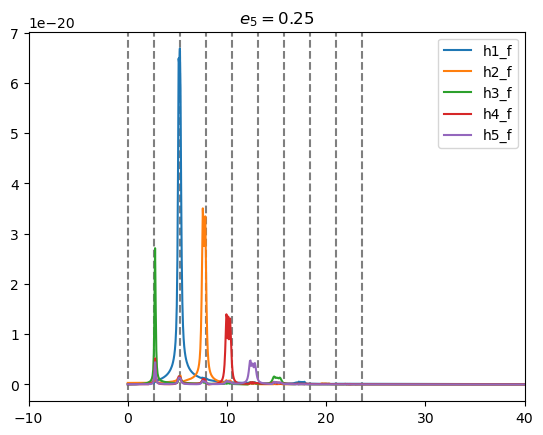

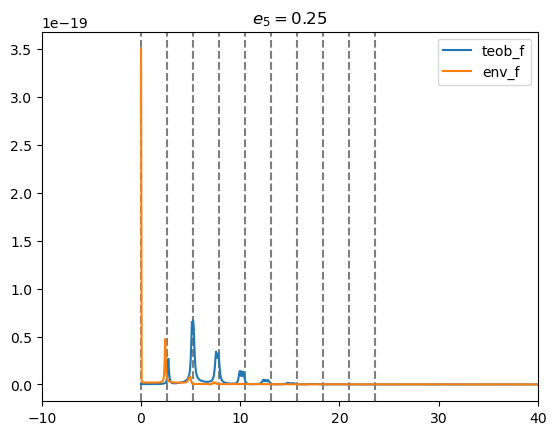

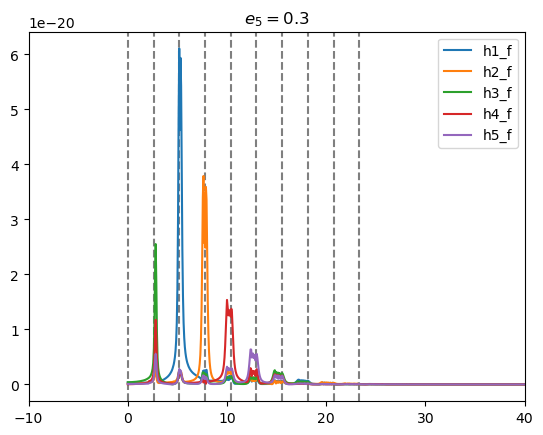

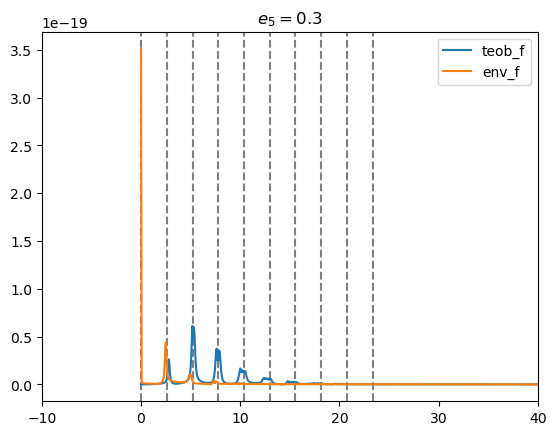

In [174]:
# Loop over all eccentricities
n1_peaks_2 = []
n2_peaks_2 = []
n3_peaks_2 = []
env_peaks_2 = []
for e in [0,0.05,0.1,0.15,0.2,0.25,0.3]:

    # Create and FT waveforms
    _, h1, h2, h3, h4, h5, s1, s2, s3, s4, s5 = get_h([1,1,1,1,1], 5, e, 30, 2, 4096, approximant='TEOBResumS')
    h1_f = make_frequency_series(h1.real()[0:4096*16])
    h2_f = make_frequency_series(h2.real()[0:4096*16])
    h3_f = make_frequency_series(h3.real()[0:4096*16])
    h4_f = make_frequency_series(h4.real()[0:4096*16])
    h5_f = make_frequency_series(h5.real()[0:4096*16])
    teob_f = make_frequency_series(s1.real()[0:4096*16])
    env_f = make_frequency_series(np.sqrt(s1.real()[0:4096*16]**2 + s1.imag()[0:4096*16]**2))

    # # Interpolate FT results to increase frequency resolution
    # interp_fs = np.linspace(0, 40, 40001)
    # wfs_f = [h1_f, h2_f, h3_f, h4_f, h5_f, teob_f, env_f]
    # for i in range(len(wfs_f)):
    #     wf_f_interpolate = interp1d(wfs_f[i].sample_frequencies, abs(wfs_f[i]), kind='quadratic', bounds_error=False, fill_value=0)
    #     wf_f_strain = wf_f_interpolate(interp_fs)
    #     wfs_f[i] = frequencyseries.FrequencySeries(wf_f_strain, np.mean(np.diff(interp_fs)))
    # h1_f, h2_f, h3_f, h4_f, h5_f, teob_f, env_f = wfs_f

    # Find location of peak modes
    n2_peak_arg = np.argmax(abs(teob_f)) # Assumes n=2 is largest for all eccentricities considered
    n2_peak = teob_f.sample_frequencies[n2_peak_arg]
    n1_range = [int(0.25*n2_peak_arg), int(0.75*n2_peak_arg)]
    n1_peak = teob_f.sample_frequencies[n1_range[0]+np.argmax(abs(teob_f[n1_range[0]:n1_range[1]]))]
    n3_range = [int(1.25*n2_peak_arg), int(1.75*n2_peak_arg)]
    n3_peak = teob_f.sample_frequencies[n3_range[0]+np.argmax(abs(teob_f[n3_range[0]:n3_range[1]]))]
    env_peak = env_f.sample_frequencies[3+np.argmax(abs(env_f[3:]))]
    n1_peaks_2.append(n1_peak)
    n2_peaks_2.append(n2_peak)
    n3_peaks_2.append(n3_peak)
    env_peaks_2.append(env_peak)

    # Make h1,...,h5 plot
    plt.plot(h1_f.sample_frequencies, abs(h1_f), label='h1_f')
    plt.plot(h2_f.sample_frequencies, abs(h2_f), label='h2_f')
    plt.plot(h3_f.sample_frequencies, abs(h3_f), label='h3_f')
    plt.plot(h4_f.sample_frequencies, abs(h4_f), label='h4_f')
    plt.plot(h5_f.sample_frequencies, abs(h5_f), label='h5_f')
    for mode in range(10):
        plt.axvline(mode*n2_peak/2, ls='dashed', c='k', alpha=0.5, zorder=-1)
    plt.title('$e_{5} = $'+str(e))
    plt.legend()
    plt.xlim(-10,40)
    plt.show()

    # Make teob plot
    plt.plot(teob_f.sample_frequencies, abs(teob_f), label='teob_f')
    plt.plot(env_f.sample_frequencies, abs(env_f), label='env_f')
    for mode in range(10):
        plt.axvline(mode*n2_peak/2, ls='dashed', c='k', alpha=0.5, zorder=-1)
    plt.title('$e_{5} = $'+str(e))
    plt.legend()
    plt.xlim(-10,40)
    plt.show()

(0.5, -0.5)

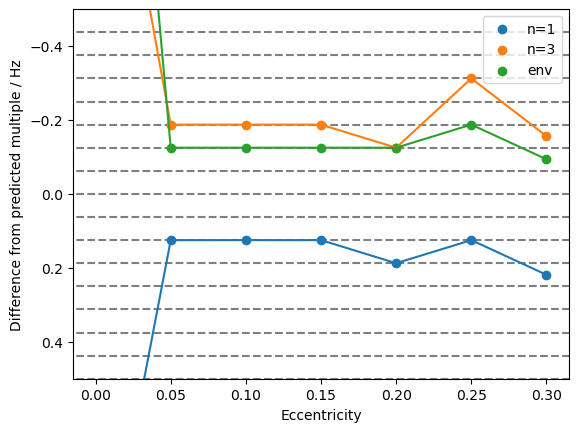

In [181]:
plt.scatter([0,0.05,0.1,0.15,0.2,0.25,0.3], np.array(n1_peaks_2)-np.array(n2_peaks_2)/2, label='n=1')
plt.scatter([0,0.05,0.1,0.15,0.2,0.25,0.3], np.array(n3_peaks_2)-3*np.array(n2_peaks_2)/2, label='n=3')
plt.scatter([0,0.05,0.1,0.15,0.2,0.25,0.3], np.array(env_peaks_2)-np.array(n2_peaks_2)/2, label='env')
plt.plot([0,0.05,0.1,0.15,0.2,0.25,0.3], np.array(n1_peaks_2)-np.array(n2_peaks_2)/2)
plt.plot([0,0.05,0.1,0.15,0.2,0.25,0.3], np.array(n3_peaks_2)-3*np.array(n2_peaks_2)/2)
plt.plot([0,0.05,0.1,0.15,0.2,0.25,0.3], np.array(env_peaks_2)-np.array(n2_peaks_2)/2)
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()
plt.hlines(np.arange(-112/32, 112/32, 1/16),-1,1,zorder=-1,colors='k',alpha=0.5,ls='dashed')
plt.ylim(ylims)
plt.xlim(xlims)
plt.xlabel('Eccentricity')
plt.ylabel('Difference from predicted multiple / Hz')
plt.legend()
plt.ylim(0.5,-0.5)

Again, issues with resolution and FT breaking down slightly at higher eccentricities prevent us observing patterns here.